In [47]:
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import duckdb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import neighbors

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTg1M4NbpnVNj_R8qYAcc4b_eS6yOpPsAk_N-gAMs7nb440-En4ZsHz-8GBxBEtzAAYrTMLkAO3VvP9/pub?gid=374058482&single=true&output=csv')
df.drop('Stock_Number',axis=1)
df

,Stock_Number,Month_of_Sale,County_of_Sale,Year,Make,Model,Color,Mileage,Purchase_Price,Buy_Fee,Added_Costs,Sale_Price,Profit,Sale_Source,Age,Year_Sold
0,R-2386,January,Linn,2011,Honda,Civic,White,131412,6800,345,512.29,9029.52,1482.52,Google,11,2022
1,R-2290,January,Johnson,2015,Hyundai,Santa Fe,Blue,110742,9825,365,1421.22,13500.00,1998.78,Website,7,2022
2,R-2391,January,Johnson,2015,Toyota,Corolla,Silver,146148,7800,0,349.82,12995.00,4145.18,Website,7,2022
3,R-2351,January,Warren,2007,Nissan,Pathfinder,Silver,170770,1000,0,349.82,6300.00,4682.07,Facebook,15,2022
4,R-2393,January,Polk,2008,Ford,Focus,Green,106767,500,0,115.00,2500.00,1995.00,Drive by,14,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,R-2166,November,Linn,2013,Hyundai,Sonata,Black,119125,6700,225,430.06,8500.00,1254.94,Google,7,2020
383,R-2178,November,Johnson,2013,Hyundai,Sonata,Gray,115917,5650,190,654.88,7995.00,1110.12,Facebook,7,2020
384,R-2201,November,Linn,2014,Ford,Fusion,White,84368,8000,275,202.64,10100.00,1732.36,Facebook,6,2020
385,R-2174,December,Johnson,2011,Toyota,Camry,Silver,136069,6300,250,286.03,8495.00,1568.97,Cars.com,9,2020


In [4]:
#Obtain some basic understanding for each year a vehicle was sold
df2 = df[ df['Buy_Fee'] > 0 ] 
df3 = df[ df['Buy_Fee'] ==0]
df2.groupby('Year_Sold').mean()

,Year,Mileage,Purchase_Price,Buy_Fee,Added_Costs,Sale_Price,Profit,Age
Year_Sold,,,,,,,,
2020,2012.011765,103144.988235,6148.823529,250.470588,547.613647,8267.657647,1300.091529,7.988235
2021,2012.315315,109895.171171,7110.567568,255.225225,588.459009,9596.556757,1652.237568,8.684685
2022,2012.376623,114000.064935,8755.519481,317.142857,562.226623,12002.254156,2424.835844,9.623377


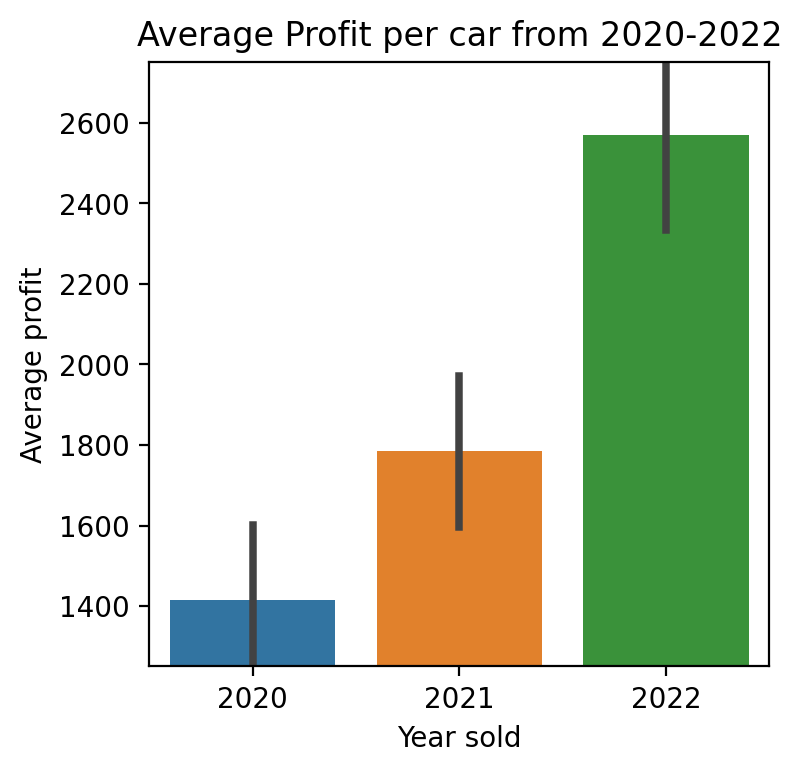

In [5]:
#Simple graph to start out to note the increase in profit seen post covid
plt.figure(figsize=(4,4),dpi=200)
sns.barplot(data=df.groupby('Year_Sold').mean(),y=df['Profit'],x=df['Year_Sold'])
plt.title('Average Profit per car from 2020-2022')
plt.xlabel('Year sold')
plt.ylim(1250,2750)
plt.ylabel('Average profit')
plt.show()

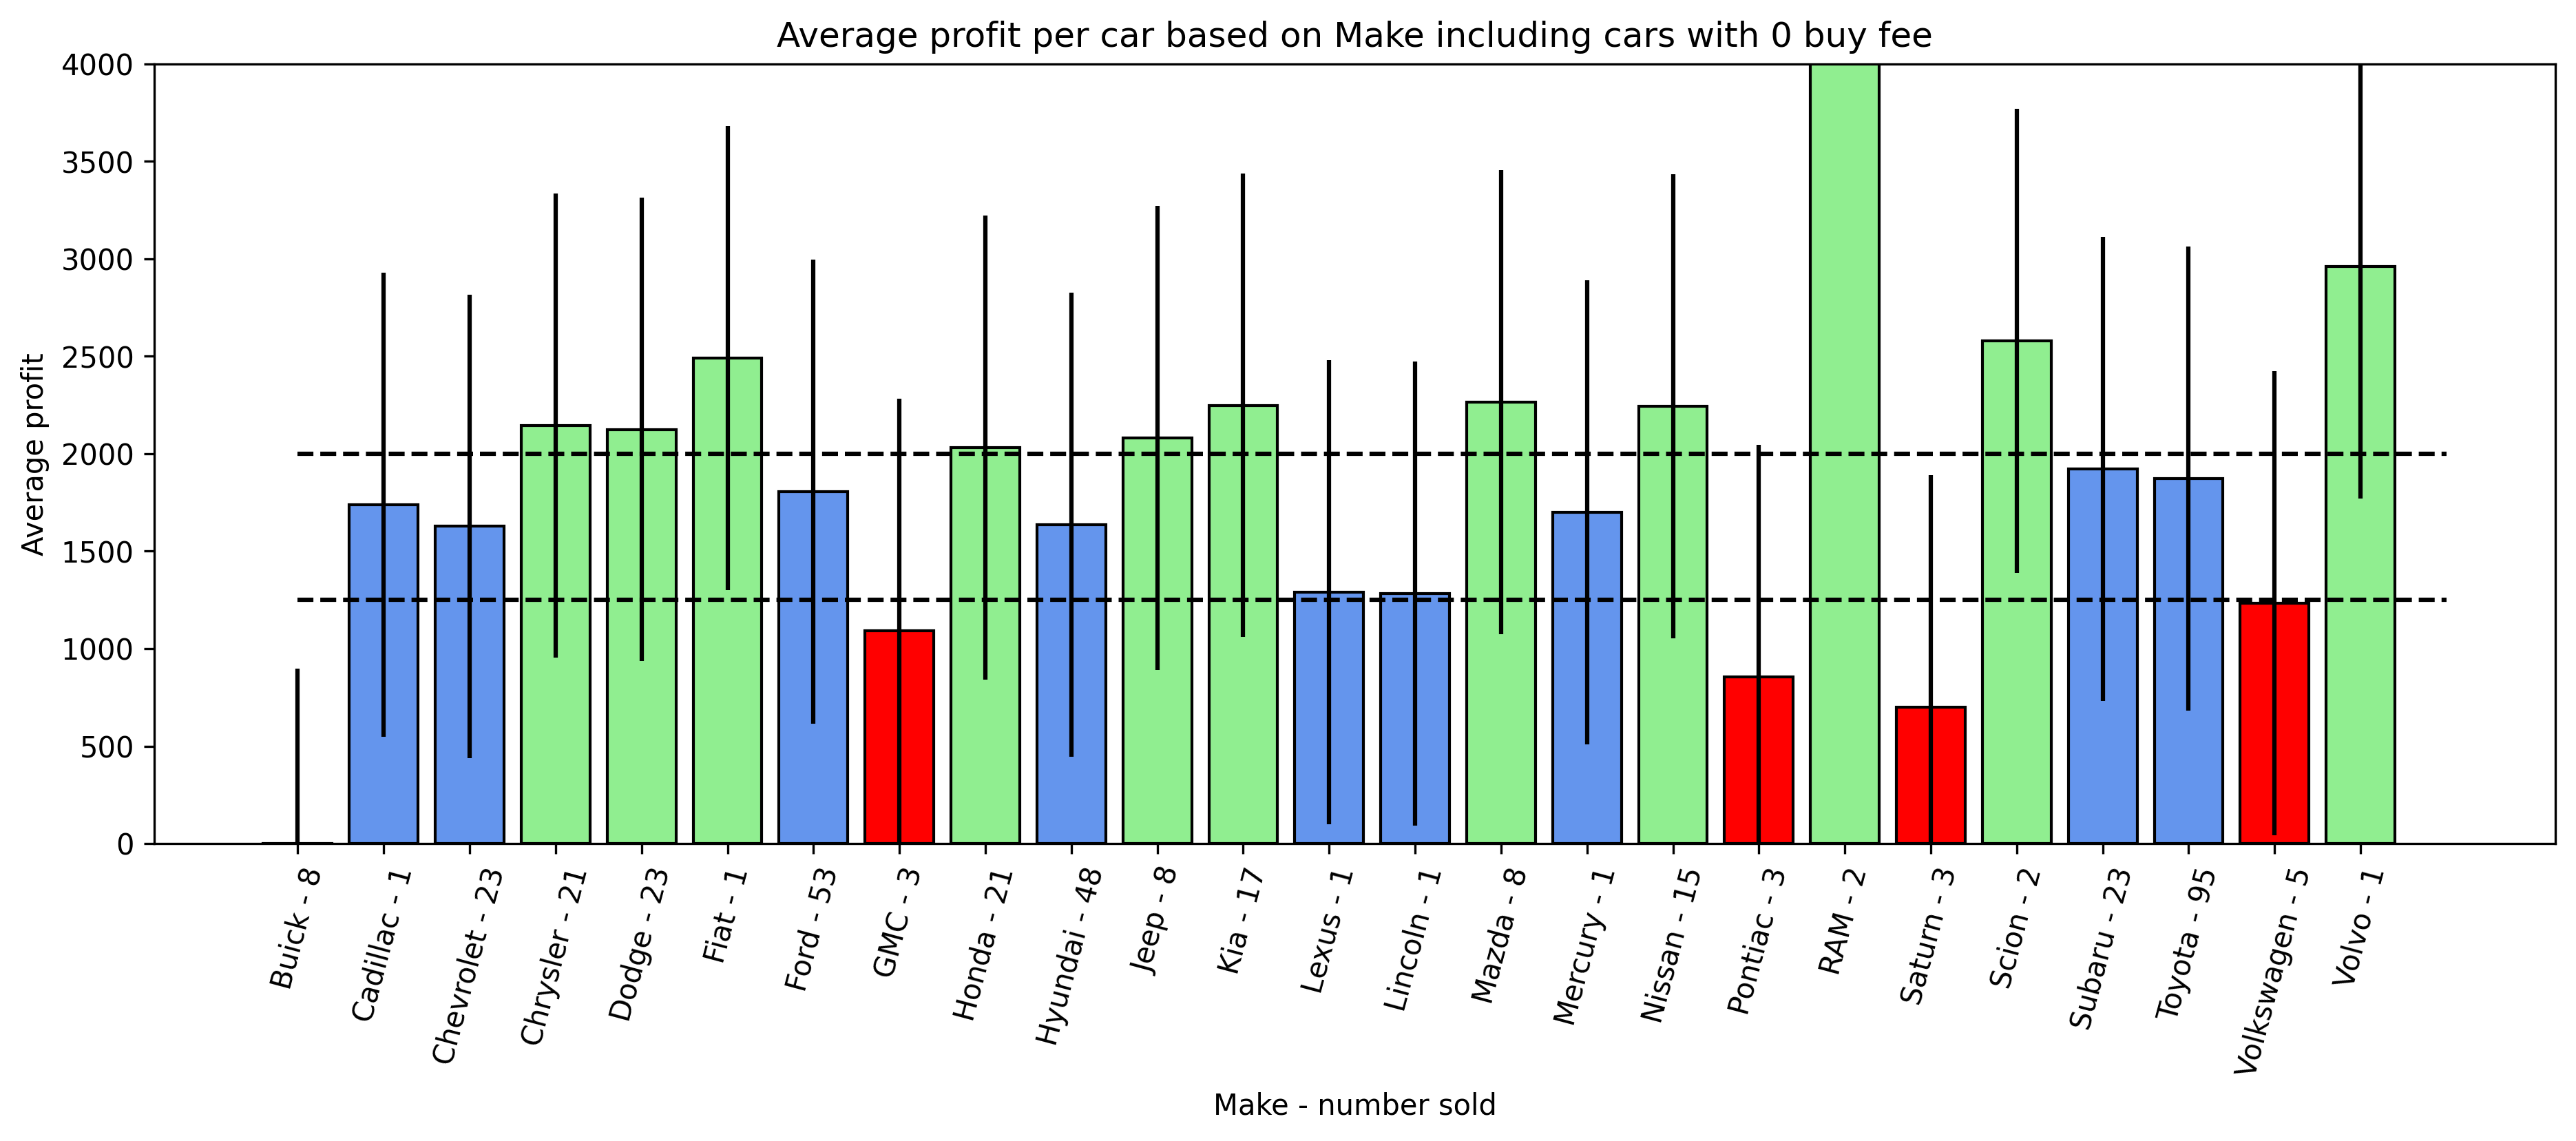

In [6]:
#Looking at the profit seen per vehicle for any vehcile 
Makes = [i for i in df['Make'].unique()]
ProfitMakes = []
Makes = sorted(Makes)
colors = ['lightgreen' if i > 2000 else ('cornflowerblue' if i > 1250 else 'red') for i in df.groupby('Make').mean()['Profit']]
for i in Makes:
    ProfitMakes.append(df.groupby('Make').mean()['Profit'][i])

for i in range(len(Makes)):
    Makes[i] = Makes[i] + ' - ' + str((df.groupby('Make').count()['Stock_Number'][i]))
plt.figure(figsize=(15,5),dpi=300)
plt.bar(height=ProfitMakes,x=Makes,edgecolor='black',color=colors,yerr=np.std(ProfitMakes))
plt.hlines(y=2000,xmin=0,xmax=25,color='black',linestyle='--')
plt.hlines(y=1250,xmin=0,xmax=25,color='black',linestyle='--')
plt.xlabel('Make - number sold')
plt.xticks(rotation=75)
plt.ylabel('Average profit')
plt.title('Average profit per car based on Make including cars with 0 buy fee')
plt.ylim(0,4000)
plt.show()

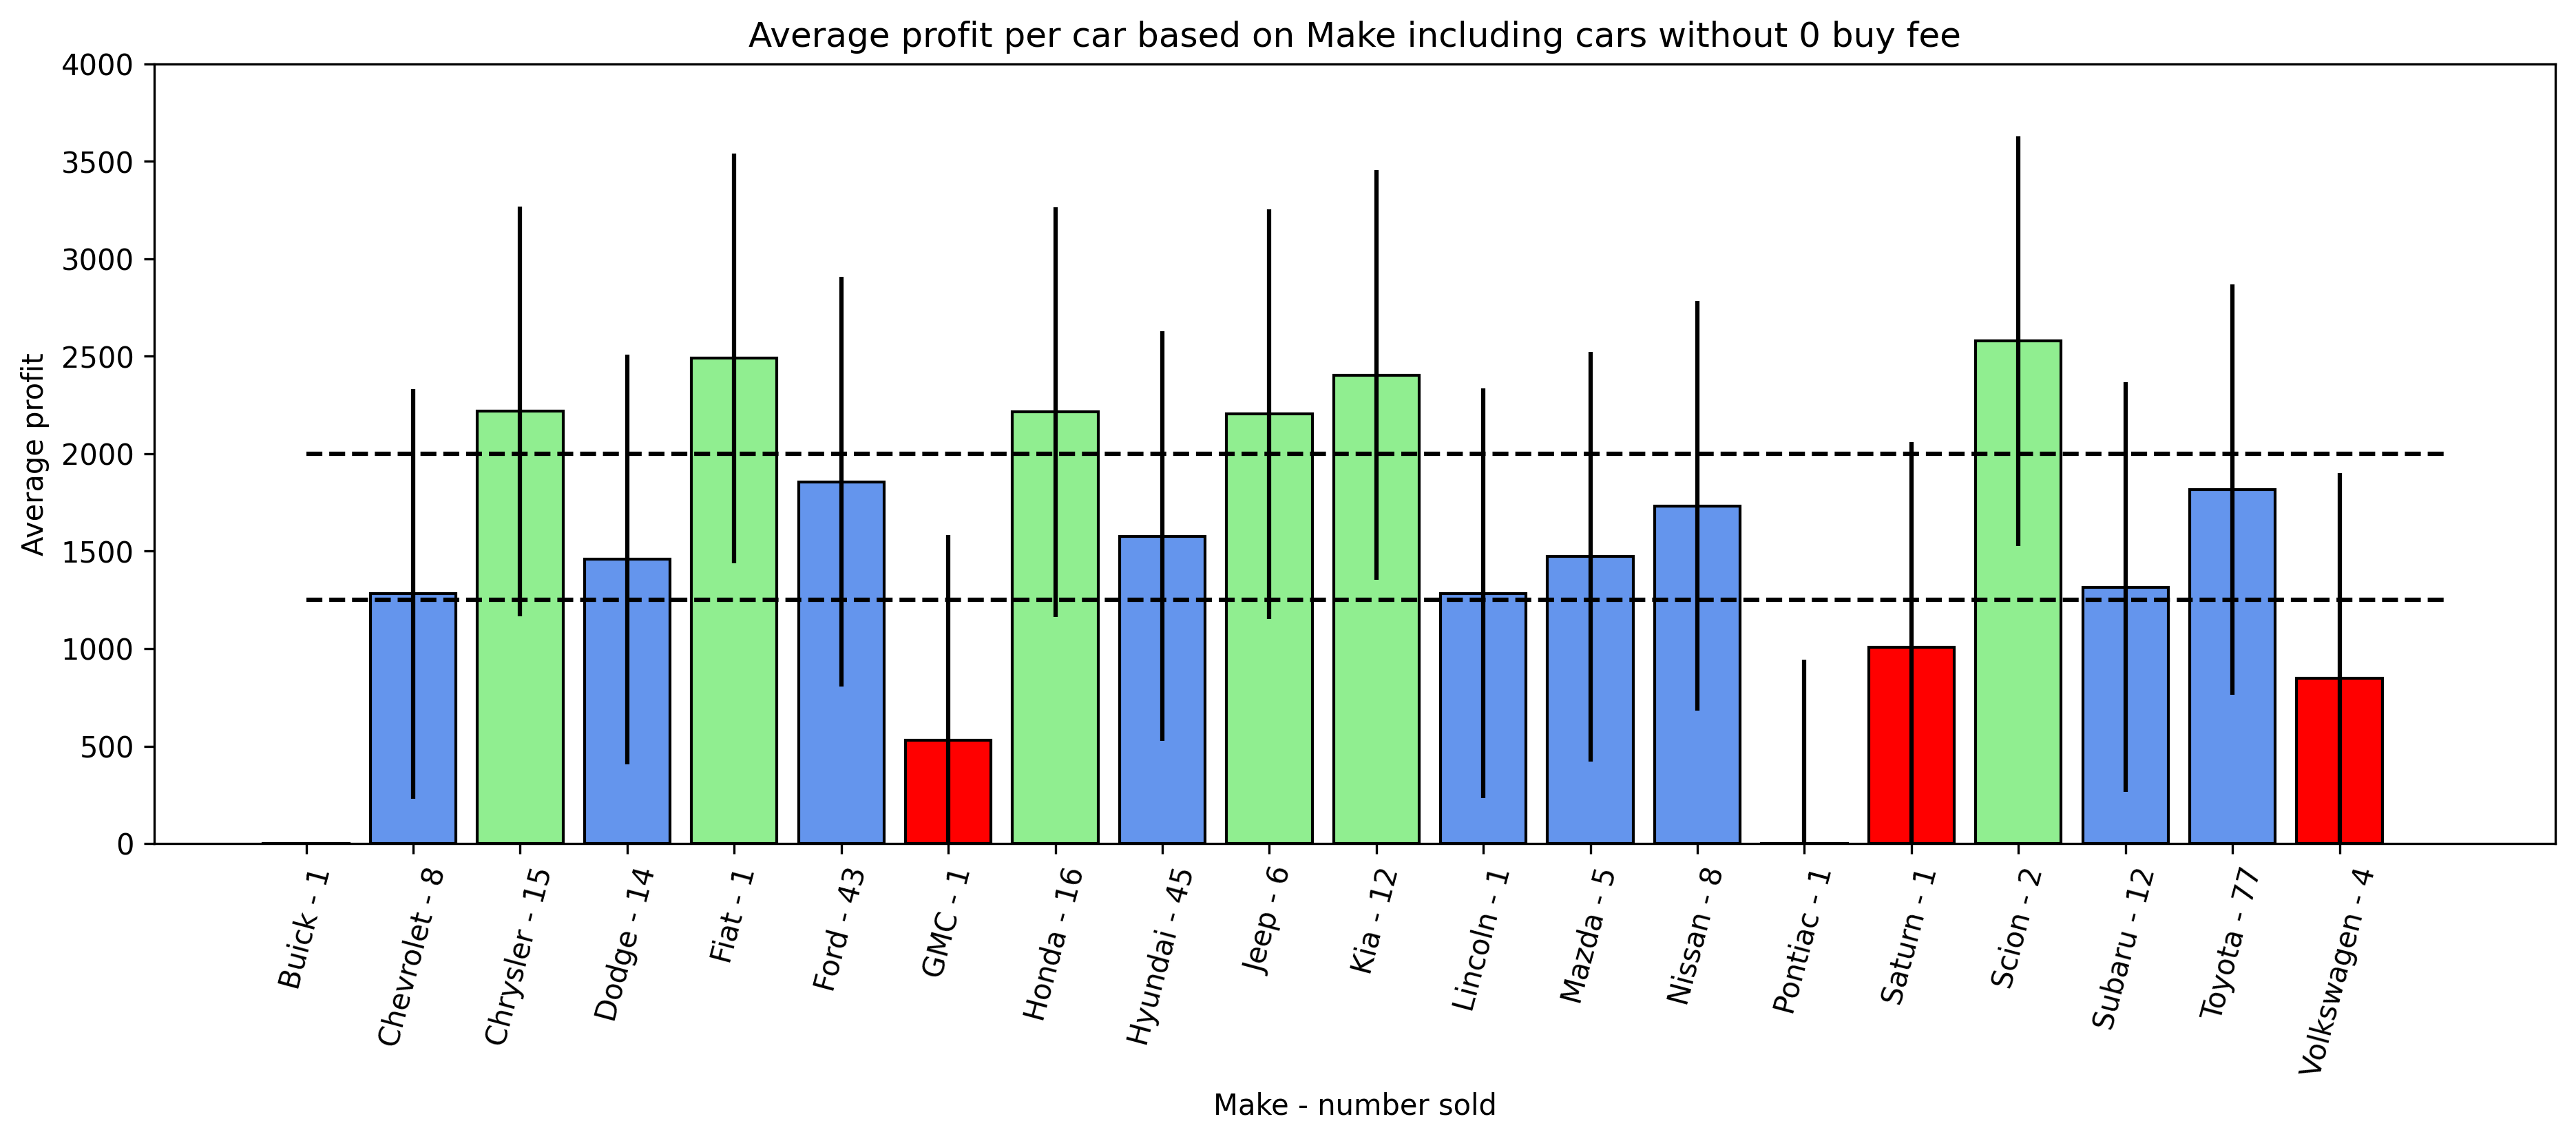

In [7]:
#Doing the same but only looking at vehicles bought at auction
Makes = [i for i in df2['Make'].unique()]
ProfitMakes = []
Makes = sorted(Makes)
colors = ['lightgreen' if i > 2000 else ('cornflowerblue' if i > 1250 else 'red') for i in df2.groupby('Make').mean()['Profit']]
for i in Makes:
    ProfitMakes.append(df2.groupby('Make').mean()['Profit'][i])
    
for i in range(len(Makes)):
    Makes[i] = Makes[i] + ' - ' + str((df2.groupby('Make').count()['Stock_Number'][i]))
plt.figure(figsize=(15,5),dpi=300)
plt.bar(height=ProfitMakes,x=Makes,edgecolor='black',color=colors,yerr=np.std(ProfitMakes))
plt.hlines(y=2000,xmin=0,xmax=20,color='black',linestyle='--')
plt.hlines(y=1250,xmin=0,xmax=20,color='black',linestyle='--')
plt.xlabel('Make - number sold')
plt.xticks(rotation=75)
plt.ylabel('Average profit')
plt.title('Average profit per car based on Make including cars without 0 buy fee')
plt.ylim(0,4000)
plt.show()


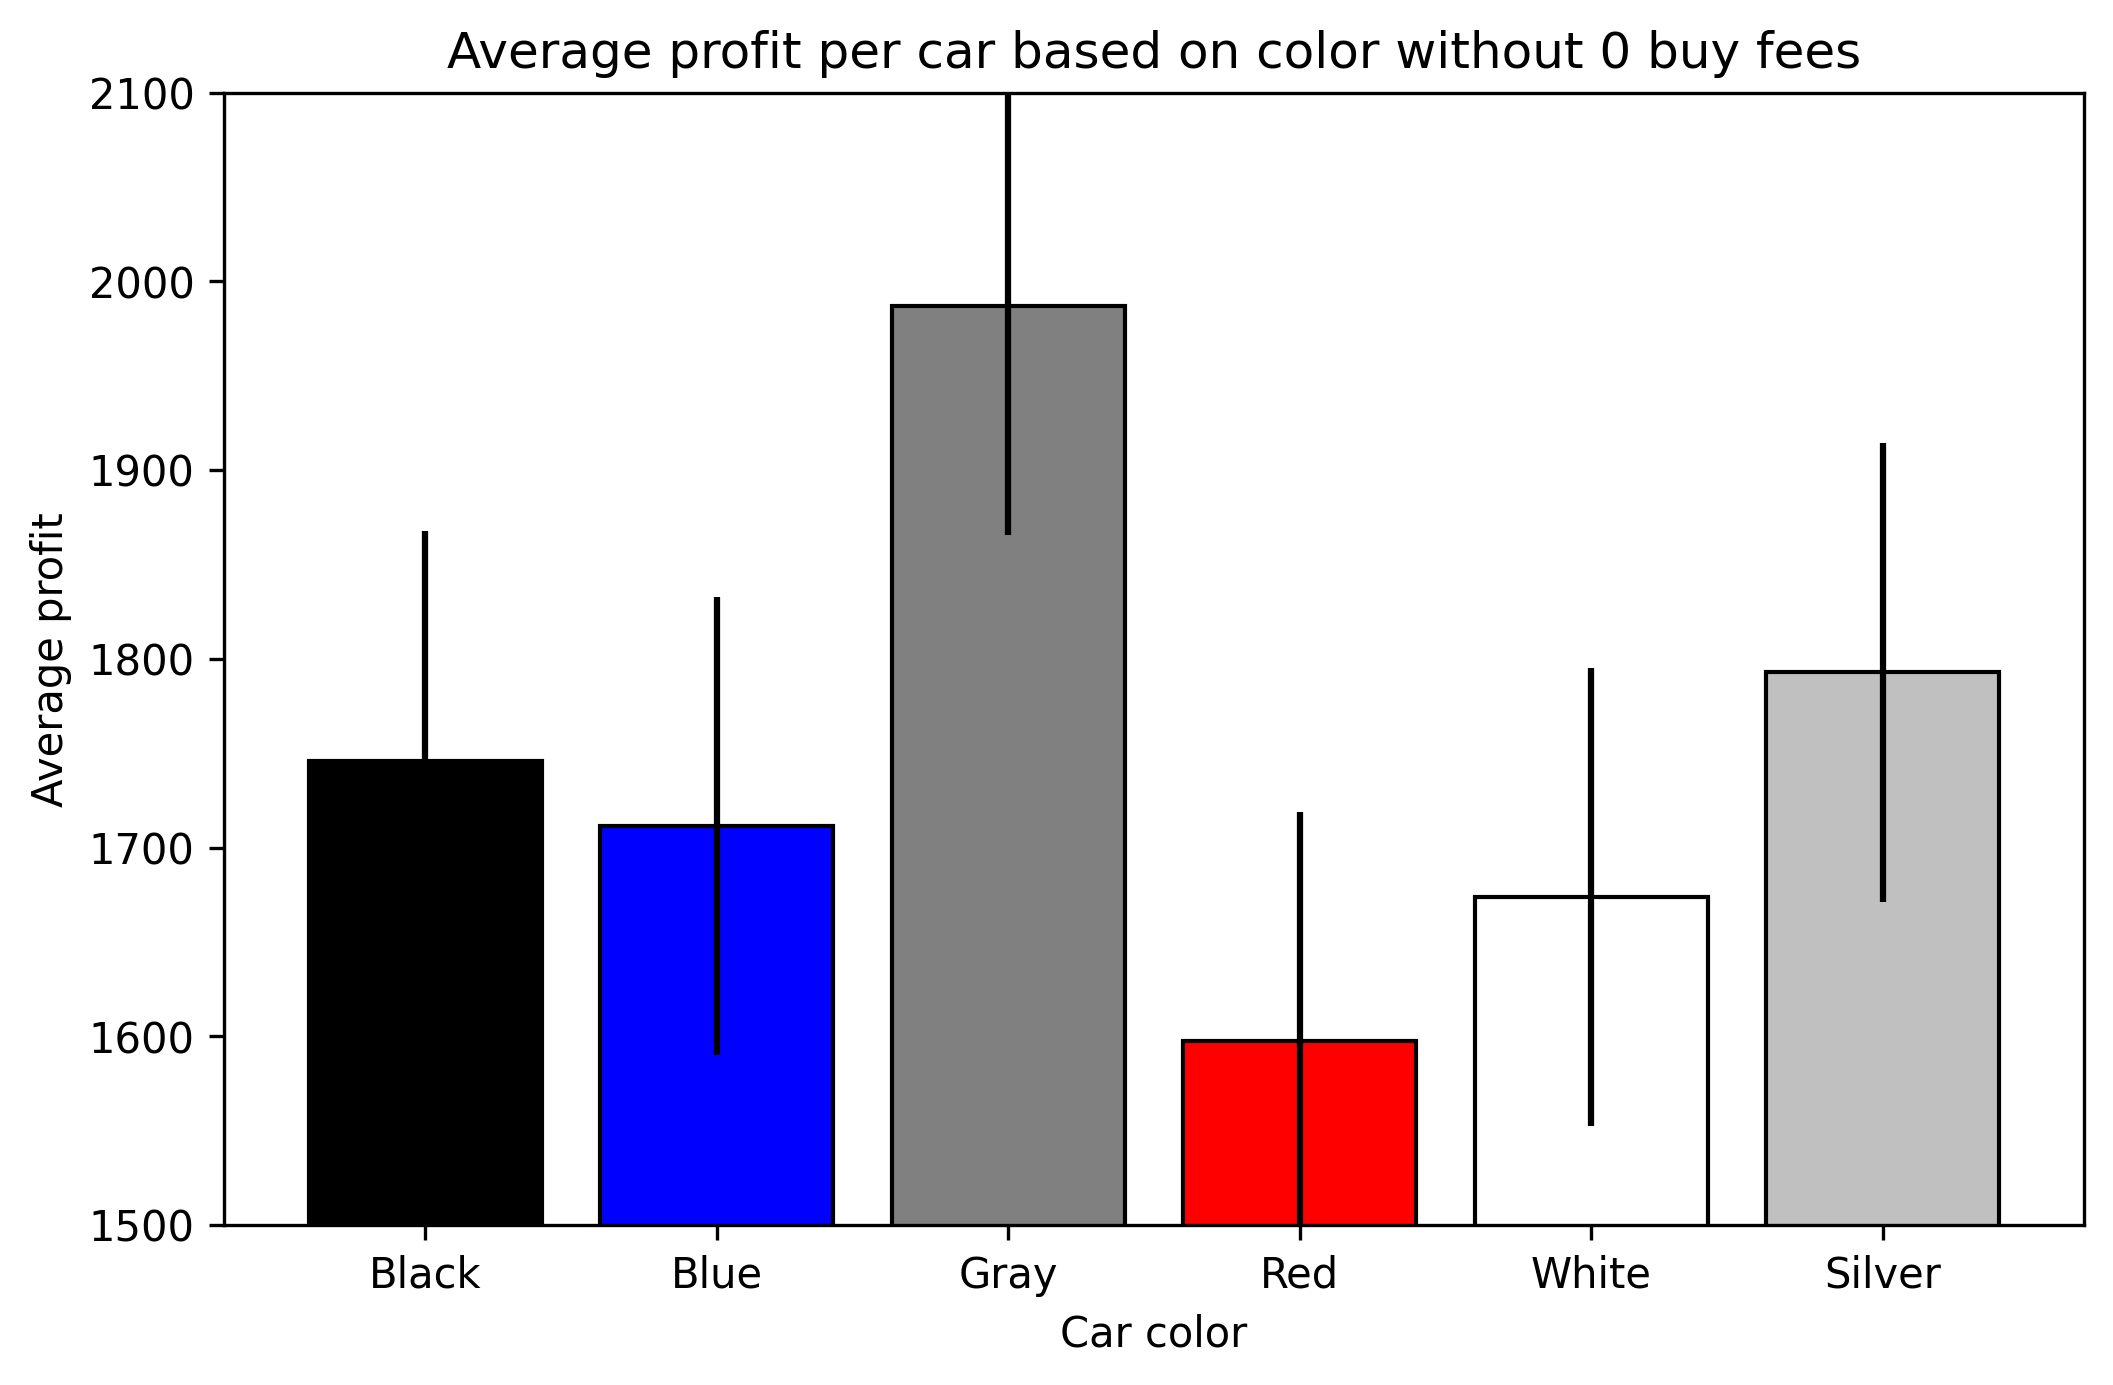

In [8]:
# excluding the 0 dollar buy-fees
# Looking at each popular color to see what the average profit is 

Colors = []
Profits = []
colors = ['Black','Blue','Gray','Red','White','Silver']
for i in colors:
    #print('\n',i + ' Cars:','\n\n',df2[ df2['Color']==i].mean())
    Profits.append(df2[df2['Color']==i].mean()['Profit'])
    Colors.append(i)

plt.figure(figsize=(8,5),dpi=300)
plt.bar(height=Profits,x=Colors,color=['Black','Blue','Gray','Red','White','Silver'],edgecolor='black',yerr=np.std(Profits))
plt.xlabel('Car color')
plt.ylabel('Average profit')
plt.title('Average profit per car based on color without 0 buy fees')
plt.ylim(1500,2100)
plt.show()

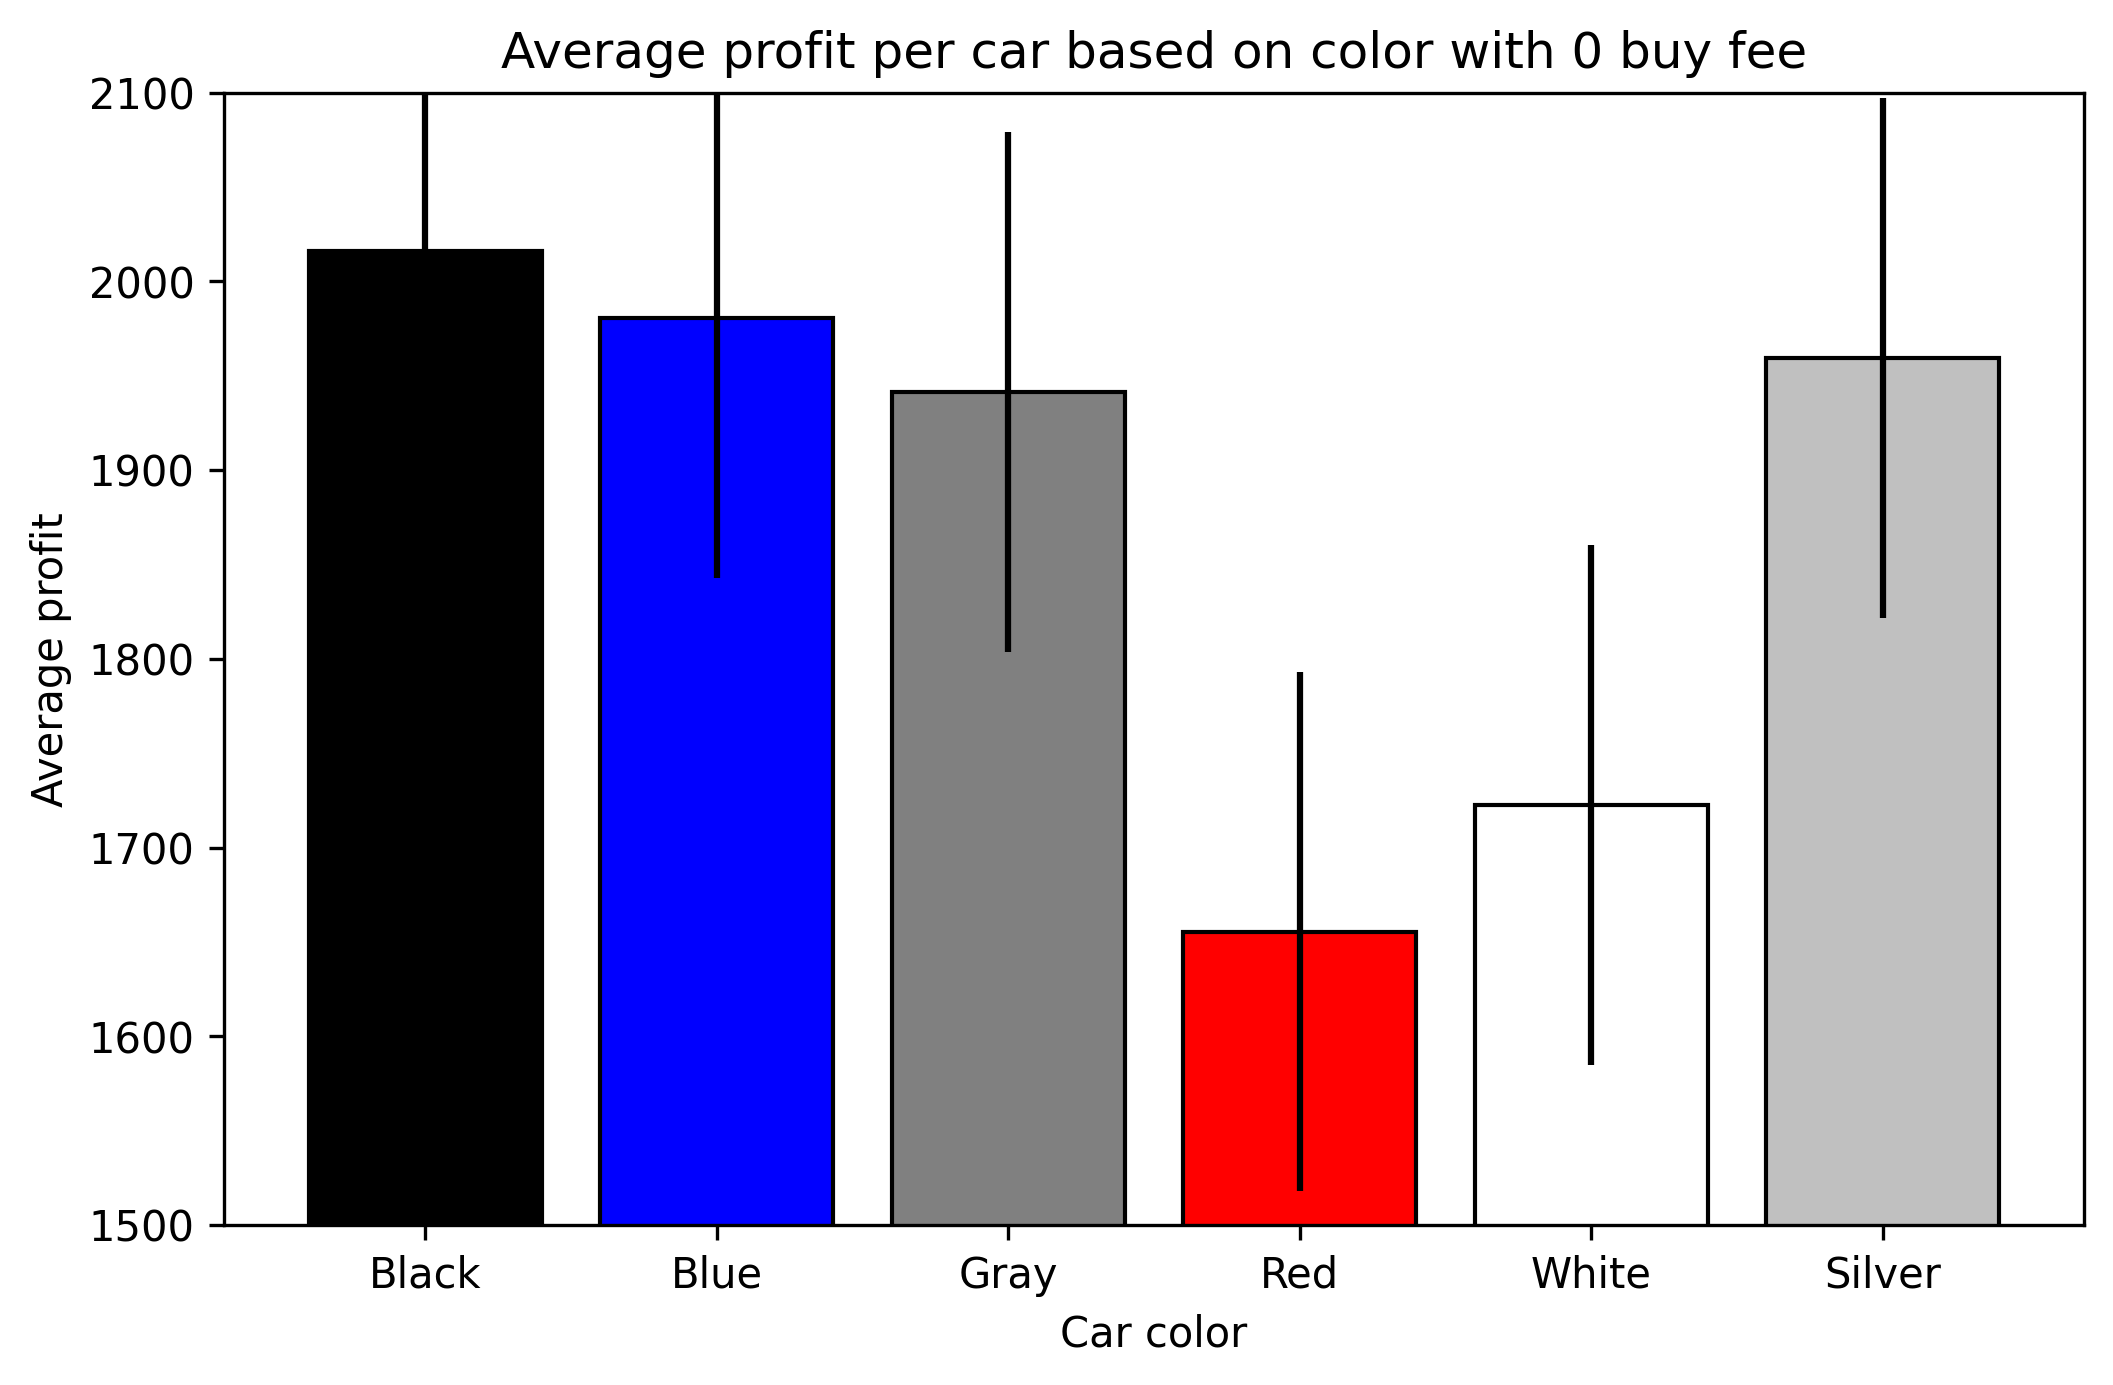

In [12]:
#Doing the same but including all cars 
Colors = []
Profits = []
colors = ['Black','Blue','Gray','Red','White','Silver']
for i in colors:
    #print('\n',i + ' Cars:','\n\n',df2[ df2['Color']==i].mean())
    Profits.append(df[df['Color']==i].mean()['Profit'])
    Colors.append(i)

plt.figure(figsize=(8,5),dpi=300)
plt.bar(height=Profits,x=Colors,color=['Black','Blue','Gray','Red','White','Silver'],edgecolor='black',yerr=np.std(Profits))
plt.xlabel('Car color')
plt.ylabel('Average profit')
plt.title('Average profit per car based on color with 0 buy fee')
plt.ylim(1500,2100)
plt.show()

In [13]:
#Create dummy variables for all categorical variables
df_dummy = pd.get_dummies(df2,drop_first=True)

# Looking at the dataset as a whole
<br>
<br>


In [33]:
#Create X and Y vatriables to perform analysis on
X = duckdb.sql("SELECT * EXCLUDE (Profit) FROM df_dummy").df()
Y = duckdb.sql("SELECT Profit FROM df_dummy").df()
#import necessary tools to perform ML, create a test train split
x_tr, x_test, y_tr, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [59]:
#Create a regression object with a random forest regressor
mod = RandomForestRegressor(random_state=1)
Reg = mod.fit(x_tr,y_tr)

#Print out some basic information -----

avg_profit = np.sqrt(mean_squared_error(Reg.predict(x_test), y_test.values))
#Average predicted profit for any given vehicle

print(f'Average profit per vehicle ${avg_profit}')

print(X.columns[np.where(Reg.feature_importances_ > .05)])
#Column names of attributes that contribute to over 5% of the explanitory power towards profit

Average profit per vehicle $865.4956043959335
Index(['Mileage', 'Purchase_Price', 'Sale_Price', 'Stock_Number_R-2270'], dtype='object')


In [55]:
#Cross Validation tuning for the Random Forest
#Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [1, 3, 5, 10, 15, None]
}
#Create a RF object , 5 fold CV
rf = RandomForestRegressor(random_state=1)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(x_tr, y_tr)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 150}
Best score: 0.3127336247281226


In [61]:
#Create a regression object with a random forest regressor this time using the tuned parameters gained from above
mod = RandomForestRegressor(max_depth=None, max_features='auto',n_estimators=150, random_state=1)
Reg = mod.fit(x_tr,y_tr)

#Print out some basic information -----

avg_profit_tuned = np.sqrt(mean_squared_error(Reg.predict(x_test), y_test.values))
#Average predicted profit for any given vehicle

print(f'Average profit per vehicle now is ${avg_profit_tuned} which is an increase of ${float(avg_profit_tuned-avg_profit)}')

print(X.columns[np.where(Reg.feature_importances_ > .05)])
#Column names of attributes that contribute to over 5% of the explanitory power towards profit


Average profit per vehicle $868.6805732172988 which is an increase of $3.1849688213653735
Index(['Mileage', 'Purchase_Price', 'Sale_Price', 'Stock_Number_R-2270'], dtype='object')


# Looking at colors now 
<br>
<br>

In [84]:
#Create X and Y vatriables to perform analysis on
#This time will be looking at color and its impacts on profit
X = duckdb.sql("SELECT COLUMNS('Color*') FROM df_dummy").df()
Y = duckdb.sql("SELECT Profit FROM df_dummy").df()
#import necessary tools to perform ML, create a test train split
x_tr, x_test, y_tr, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [127]:
#Create a regression object with a random forest regressor
mod = RandomForestRegressor(random_state=1)
Reg = mod.fit(x_tr,y_tr)

#Print out some basic information -----

avg_profit = np.sqrt(mean_squared_error(Reg.predict(x_test), y_test.values))
#Average predicted profit for any given vehicle

print(f'Average profit per vehicle ${avg_profit}')

print(X.columns[np.where(Reg.feature_importances_ > .1)])
#Column names of color that contribute to over 10% of the explanitory power towards profit

Average profit per vehicle $1099.497515320794
Index(['Color_Gray', 'Color_Red', 'Color_White'], dtype='object')


In [86]:
#Cross Validation tuning for the Random Forest for color differences
#Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 150, 200, 250, 300 , 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [1, 3, 5, 10, 15, None]
}
#Create a RF object , 5 fold CV
rf = RandomForestRegressor(random_state=1)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(x_tr, y_tr)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 500}


In [91]:
#Create a regression object with a random forest regressor this time using the tuned parameters gained from above
mod = RandomForestRegressor(max_depth=1, max_features='sqrt',n_estimators=500, random_state=1)
Reg = mod.fit(x_tr,y_tr)

#Print out some basic information -----

avg_profit_tuned = np.sqrt(mean_squared_error(Reg.predict(x_test), y_test.values))
#Average predicted profit for any given vehicle

print(f'Average profit per vehicle now is ${avg_profit_tuned} which is an increase of ${float(avg_profit_tuned-avg_profit)}')

print(X.columns[np.where(Reg.feature_importances_ > .1)])
#Column names of attributes that contribute to over 10% of the explanitory power towards profit

#In this case Cross Validation tuning made the model slightly worse and should stick to original results

Average profit per vehicle now is $1090.9745004857364 which is an increase of $-8.523014835057666
Index(['Color_Gray', 'Color_Red', 'Color_Silver', 'Color_White'], dtype='object')


In [129]:
pred = Reg.predict(x_test)

#Get the indicies of the colors that have over 10% explanitory power towards profit
grays = np.where(x_test['Color_Gray']==1)[0]
gray_sum = 0
reds = np.where(x_test['Color_Red']==1)[0]
red_sum =0
silvers = np.where(x_test['Color_Silver']==1)[0]
silver_sum = 0
whites = np.where(x_test['Color_White']==1)[0]
white_sum = 0

#Add all the predicted sums together based on color
for i in grays:
    gray_sum += pred[i]
for i in reds:
    red_sum += pred[i]
for i in silvers:
    silver_sum += pred[i]
for i in whites:
    white_sum +=pred[i]

print(f'Average predicted profit per Gray car: ${gray_sum/len(grays)}')
print(f'Average predicted profit per Red car: ${red_sum/len(reds)}')
print(f'Average predicted profit per Silver car: ${silver_sum/len(silvers)}')
print(f'Average predicted profit per White car: ${white_sum/len(whites)}')

Average predicted profit per Gray car: $1991.1723173070666
Average predicted profit per Red car: $1649.8409623966359
Average predicted profit per Silver car: $1668.4345928102043
Average predicted profit per White car: $1795.9702490909401


In [131]:
print(f'''With the above results we can see that certain colors have a higher predicted average profit than others.
Some perform better by a good amount. This analysis was only done on a few colors you could expand and see all colors.''')

With the above results we can see that certain colors have a higher predicted average profit than others.
Some perform better by a good amount. This analysis was only done on a few colors you could expand and see all colors.


# Looking at different car makes
<br>
<br>

In [135]:
#Create X and Y vatriables to perform analysis on
#This time will be looking at color and its impacts on profit
X = duckdb.sql("SELECT COLUMNS('Make*') FROM df_dummy").df()
Y = duckdb.sql("SELECT Profit FROM df_dummy").df()
#import necessary tools to perform ML, create a test train split
x_tr, x_test, y_tr, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [173]:
#Create a regression object with a random forest regressor
mod = RandomForestRegressor(random_state=1)
Reg = mod.fit(x_tr,y_tr)

#Print out some basic information -----

avg_profit = np.sqrt(mean_squared_error(Reg.predict(x_test), y_test.values))
#Average predicted profit for any given vehicle

print(f'Average profit per vehicle ${avg_profit}')

print(X.columns[np.where(Reg.feature_importances_ > .1)])
#Column names of color that contribute to over 10% of the explanitory power towards profit

#With only 1 make contributing to over 10% of the explanitory power of profit I will look at the top selling brands instead.

Average profit per vehicle $1163.2856993232986
Index(['Make_Subaru'], dtype='object')


In [172]:
#Cross Validation tuning for the Random Forest for color differences
#Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 150, 200, 250, 300 , 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [1, 3, 5, 10, 15, None]
}
#Create a RF object , 5 fold CV
rf = RandomForestRegressor(random_state=1)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(x_tr, y_tr)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

KeyboardInterrupt: 

In [146]:
#Create a regression object with a random forest regressor this time using the tuned parameters gained from above
mod = RandomForestRegressor(max_depth=3, max_features='sqrt',n_estimators=300, random_state=1)
Reg = mod.fit(x_tr,y_tr)

#Print out some basic information -----

avg_profit_tuned = np.sqrt(mean_squared_error(Reg.predict(x_test), y_test.values))
#Average predicted profit for any given vehicle

print(f'Average profit per vehicle now is ${avg_profit_tuned} which is an increase of ${float(avg_profit_tuned-avg_profit)}')

print(X.columns[np.where(Reg.feature_importances_ > .1)])
#Column names of attributes that contribute to over 10% of the explanitory power towards profit
#since our test data set is so small we will have to condense these down into categories that have more than a couple of data points

#In this case Cross Validation tuning made the model slightly worse and should stick to original results

Average profit per vehicle now is $1082.39912671903 which is an increase of $-80.88657260426862
Index(['Make_Chevrolet', 'Make_Honda', 'Make_Pontiac', 'Make_Subaru'], dtype='object')


In [141]:
#Ford, Hyundai, Subaru, Toyota, Honda, Other

55

In [174]:
#Get the indicies of the brands that have enough data points to do a small test
toyotas = np.where(x_test['Make_Toyota']==True)[0]
toyota_sum = 0
fords = np.where(x_test['Make_Ford']==True)[0]
ford_sum = 0
hyundais = np.where(x_test['Make_Hyundai']==True)[0]
hyundai_sum = 0
#Get the indicie of all other vehicles
others = [i for i in range(len(x_test)) if i not in np.concatenate([toyotas,fords,hyundais])]
other_sum = 0 


pred = Reg.predict(x_test)
for i in toyotas:
    toyota_sum += pred[i]
for i in fords:
    ford_sum += pred[i]
for i in hyundais:
    hyundai_sum += pred[i]
for i in others:
    other_sum += pred[i]
    
print(f'Average predicted profit for toyotas: ${toyota_sum/len(toyotas)}')
print(f'Average predicted profit for fords: ${ford_sum/len(fords)}')
print(f'Average predicted profit for hyundais: ${hyundai_sum/len(hyundais)}')
print(f'Average predicted profit for other makes: ${other_sum/len(others)}')

Average predicted profit for toyotas: $1807.047167390432
Average predicted profit for fords: $1945.7291948842549
Average predicted profit for hyundais: $1611.3310440299967
Average predicted profit for other makes: $1555.7408045161533


In [175]:
print(f'''This results tell us that Fords and Toyotas are predicted to do much better than other makes.
Unfortunately the test size is incredibly small (55 sample points) This makes it very difficult to draw a meaningful conclusion.
However this can be used as a general guideline and maybe be more cautious when buying Hyundais or other brands.''')

This results tell us that Fords and Toyotas are predicted to do much better than other makes.
Unfortunately the test size is incredibly small (55 sample points) This makes it very difficult to draw a meaningful conclusion.
However this can be used as a general guideline and maybe be more cautious when buying Hyundais or other brands.


# Future analysis as requested:
<br>
<br>